In [53]:
# Initial installation/preparation steps. Only need to be run once per environment.

# !pip install librosa boto3 requests tqdm opencv-python torch
# Get biggan repo:
#!git clone https://github.com/huggingface/pytorch-pretrained-BigGAN.git 

# If used on a GPU environment, make sure to not install default pytorch but pytorch for cuda.

In [54]:
#!pip install librosa --upgrade

In [55]:
# What did I change last? : I cut off the top-frequencies and changed growth-rate to harmonic growth.

In [56]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from tqdm import tqdm
import cv2 as cv
import librosa
from sklearn.decomposition import PCA, KernelPCA
sys.path.append("./pytorch-pretrained-BigGAN")
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample)


In [120]:
truncation = 0.5
extra_detail = 0.91 # Higher Value = more detail. valid range: [0;1[
max_frequency_level = 11000 # All Frequencies higher than this will not be considered.
low_frequency_skip = 16 # skip the first n herz
frequency_band_growth_rate = 1.015
smoothing_factor = 0.1 # How much the noise will be smothened. 0 = no smoothing, 1 = full smoothing
iterations = 2 # How many times to apply the smoothing algorithm. Higher value = more smoothing

debug = True # wether or not to display the weights for the weighted sum at each timestep.

# Free and royalty free music form pixabay.com
class_labels = ['soap bubble', "mushroom", "strawberry", "orange", "alp"] # List of labels from imagenet. See https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a for a full list.
filename = "audio/guitar.wav"


In [121]:
model = BigGAN.from_pretrained('biggan-deep-128')
class_vector = one_hot_from_names(class_labels, batch_size=len(class_labels))
model.to('cuda')
# Noise shape is 128

sound_data, sampling_rate = librosa.load(filename, sr=None)
print(sound_data.shape, sampling_rate)

(5240448,) 44100


In [122]:
import math
seconds = len(sound_data)/sampling_rate
video_frame_count = int(math.ceil(seconds*30))
step_size = int(math.ceil(sampling_rate/30))
samples_per_frame = sampling_rate
#samples_per_frame = step_size * 5

softmax_rep_factors = [1]

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

frequency_samples = []
smoothing_level = 1
for i in range(0, sound_data.shape[0]-(samples_per_frame+smoothing_level), step_size):
    X = np.fft.rfft(sound_data[i:samples_per_frame+i])
    Xdb = 20*np.log10(np.abs(X))
    db_sum = np.sum(Xdb)
    top_n_freqs = np.zeros_like(Xdb)
    softmax_xdb = Xdb.copy()
    for softmax_factor in softmax_rep_factors:
        softmax_xdb = softmax(softmax_xdb)
        top_n_freqs += softmax_xdb * softmax_factor
        softmax_xdb[np.argmax(softmax_xdb)] = -10e3
    Xdb = top_n_freqs
    Xdb = Xdb ** (1-extra_detail)
    biggest_prob_index = np.argmax(Xdb)
    biggest_probability = Xdb[biggest_prob_index]
    frequency_sums = []
    sum_range = 10
    precise_sum_range = 1.0
    sum_start = low_frequency_skip
    max_freq = min(max_frequency_level, sampling_rate//2)
    sum_increment = frequency_band_growth_rate
    while sum_range*sum_increment + sum_start < max_freq:
        precise_sum_range *= sum_increment
        sum_range = int(precise_sum_range)
        new_index = sum_start + sum_range
        if len(Xdb[sum_start:new_index]) > 1:
            frequency_sums.append(np.mean(Xdb[sum_start:new_index]))
        sum_start = new_index
    frequency_samples.append(np.nan_to_num(np.array(frequency_sums), nan=0, posinf=50, neginf=-50))
frequency_samples = np.array(frequency_samples)

In [123]:
#Smoothing the noise
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=frequency_samples.shape[1])
reference_noise = noise_vector[0]
original_noises = []
for i in range(len(noise_vector)):
    original_noises.append(noise_vector[i])
sorted_noises = []

while len(sorted_noises) < len(noise_vector):
    # Use the correlation of x and reference_noise as measure
    distances = []
    for x in original_noises:
        correlation = np.corrcoef(reference_noise, x)[0,1]
        distances.append(correlation)
    closest_noise_index = np.argmin(distances)

    sorted_noises.append(original_noises[closest_noise_index])
    reference_noise = original_noises.pop(closest_noise_index)
noise_vector = sorted_noises

for _ in range(iterations):
    for i in range(1, len(noise_vector)):
        noise_vector[i] = noise_vector[i-1] * smoothing_factor + noise_vector[i] * (1-smoothing_factor)

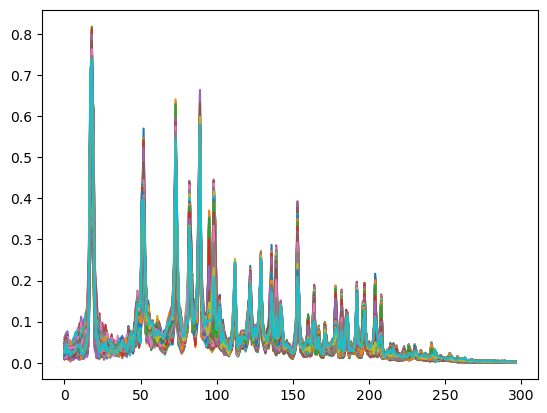

(3535, 297)


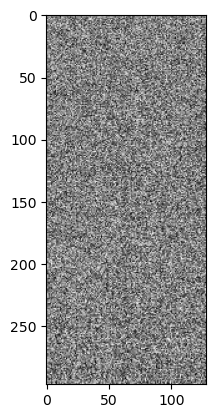

In [124]:
plt.plot(frequency_samples[:100, :].T / np.max(frequency_samples))
plt.show()
print(frequency_samples.shape)
plt.imshow(noise_vector, cmap='gray')

In [125]:
if debug:
    display = np.zeros((frequency_samples.shape[1], frequency_samples.shape[1]))
    for sample in frequency_samples:
        display[1:] = display[:-1]
        row = np.zeros_like(sample)
        display[0] = sample
        cv.imshow("display", cv.resize(display, (500, 500)))
        if cv.waitKey(10) == ord("q"):
            break
    cv.destroyAllWindows()

In [126]:
frames_per_class = video_frame_count//(len(class_labels)-1)
classes_from = class_vector[:-1]
classes_to = class_vector[1:]

i = 0
images = []
for class_from, class_to in zip(classes_from, classes_to):
    interpolations = np.linspace(class_from, class_to, frames_per_class)
    for interpolation in interpolations:
        if i >= len(frequency_samples):
            break
        interpolation_factors = frequency_samples[i]
        # Take weighted sum of noise vectors using interpolation factors
        
        final_noise = np.zeros_like(noise_vector[0])
        for _, interpolation_factor in enumerate(interpolation_factors):
            final_noise += noise_vector[_] * interpolation_factor
        noise_vec = np.clip(final_noise, -1, 1)
        #noise_vec = torch.from_numpy(noise_vec).unsqueeze(0).to('cuda')
        i += 1
        torch_noise = torch.from_numpy(np.float32(noise_vec)).unsqueeze(0)
        torch_noise = torch_noise.to('cuda')
        torch_class = torch.from_numpy(np.array([interpolation]))
        torch_class = torch_class.to('cuda')
        with torch.no_grad():
            output = model(torch_noise, torch_class, truncation)
            output = output.to("cpu")
            img = output[0]
        np_img = img.permute(1, 2, 0).numpy()
        img_max = np.max(np_img)
        img_min = np.min(np_img)
        np_img = (np_img - img_min) / (img_max - img_min)
        images.append(img)
        print(i/len(frequency_samples))
    

0.0002828854314002829
0.0005657708628005657
0.0008486562942008486
0.0011315417256011315
0.0014144271570014145
0.0016973125884016972
0.0019801980198019802
0.002263083451202263
0.002545968882602546
0.002828854314002829
0.0031117397454031117
0.0033946251768033945
0.0036775106082036777
0.0039603960396039604
0.004243281471004243
0.004526166902404526
0.004809052333804809
0.005091937765205092
0.005374823196605375
0.005657708628005658
0.005940594059405941
0.006223479490806223
0.006506364922206506
0.006789250353606789
0.007072135785007072
0.007355021216407355
0.007637906647807638
0.007920792079207921
0.008203677510608205
0.008486562942008486
0.00876944837340877
0.009052333804809052
0.009335219236209336
0.009618104667609617
0.009900990099009901
0.010183875530410185
0.010466760961810467
0.01074964639321075
0.011032531824611032
0.011315417256011316
0.011598302687411598
0.011881188118811881
0.012164073550212163
0.012446958981612447
0.01272984441301273
0.013012729844413012
0.013295615275813296
0.013

In [127]:
rgb_images = []
for img in images:
    img = img.permute(1, 2, 0).numpy()
    max_val = np.max(img)
    min_val = np.min(img)
    img = (img - min_val) / (max_val - min_val)
    rgb_images.append(img)

while len(rgb_images) < video_frame_count:
    rgb_images.append(rgb_images[-1])

video_writer = cv.VideoWriter('sound_walk.avi', cv.VideoWriter_fourcc(*'MJPG'), 30, (rgb_images[0].shape[0], rgb_images[0].shape[0]))
for img in rgb_images:
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    video_writer.write((img * 255).astype(np.uint8))
video_writer.release()

In [128]:
import ffmpeg
import os
input_video = ffmpeg.input('sound_walk.avi')
input_audio = ffmpeg.input(f'{filename}')
result_name = "final_result.mp4"
if os.path.exists(result_name):
    os.remove(result_name)
ffmpeg.concat(input_video, input_audio, v=1, a=1).output('final_result.mp4').run()

(None, None)